In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
misconceptions = pd.read_csv('kaggle/input/eedi-mining-misconceptions-in-mathematics/misconception_mapping.csv', index_col='MisconceptionId')
train = pd.read_csv('kaggle/input/eedi-mining-misconceptions-in-mathematics/train.csv')
test = pd.read_csv('kaggle/input/eedi-mining-misconceptions-in-mathematics/test.csv')
train_melted = pd.read_csv('kaggle/input/eedi-mining-misconceptions-in-mathematics/train_melted.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'train_melted.csv'

## EDA

In [4]:
print(f"train: {train.shape[0]} problems")
print(f"test: {test.shape[0]} problems")
print(f"misconceptions: {misconceptions.shape[0]} misconceptions")

train: 1869 problems
test: 3 problems
misconceptions: 2587 misconceptions


In [5]:
print(f"train_melted: {train_melted.shape[0]} answer options")
print(f"no label: {train_melted['MisconceptionId'].isna().sum()}")
print(f"unique label: {(train_melted['MisconceptionId'].value_counts() == 1).sum()}")


NameError: name 'train_melted' is not defined

In [11]:
# Count the number of occurrences of each misconception in train_melted
misconception_counts = train_melted['MisconceptionId'].value_counts()

# Create a filtered misconceptions DataFrame
misconceptions_short = misconceptions.loc[misconception_counts[misconception_counts >= 2].index]

misconceptions_short.shape
# misconceptions_short.to_csv('misconceptions_short.csv')

(857, 1)

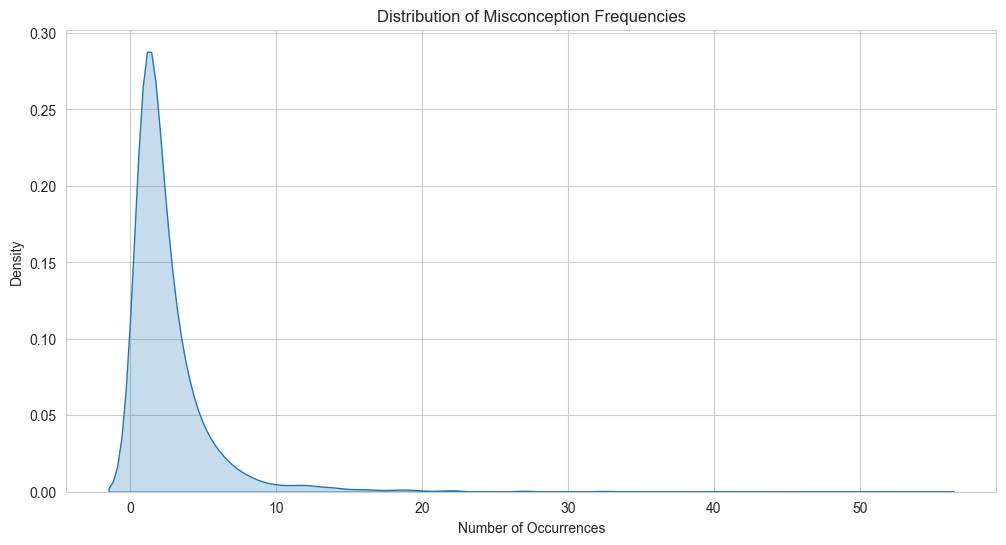

Percentage of answer options with no misconception: 41.5%


In [6]:
# Count misconceptions across all answer options and get value counts
misconception_counts = train[['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']].melt()['value'].dropna()
misconception_value_counts = misconception_counts.value_counts()

plt.figure(figsize=(12,6))
sns.kdeplot(data=misconception_value_counts.values, fill=True)
plt.title('Distribution of Misconception Frequencies')
plt.xlabel('Number of Occurrences') 
plt.ylabel('Density')
plt.show()

# Calculate total number of answer options
total_answers = train[['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']].size

# Count number of null misconceptions
null_misconceptions = train[['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']].isna().sum().sum()

# Calculate and print percentage
pct_no_misconception = (null_misconceptions / total_answers) * 100
print(f"Percentage of answer options with no misconception: {pct_no_misconception:.1f}%")


## Create train_melted 

In [6]:
train.head(1)

,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText,MisconceptionAId,MisconceptionBId,MisconceptionCId,MisconceptionDId
0,0,856,Use the order of operations to carry out calculations involving powers,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets need to go to make the answer equal \( 13 \) ?,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets,NaN,NaN,NaN,1672.0


In [7]:
#########################
# Create train_melted 
#########################

# Define the identifier columns
id_cols = [
    'QuestionId', 'ConstructId', 'ConstructName', 
    'SubjectId', 'SubjectName', 'CorrectAnswer', 'QuestionText'
]

# Define the corresponding Answer options
answer_cols = ['AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText']
misconception_cols = ['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']

# Melt Answer Text
text_melted = train.melt(
    id_vars=id_cols,
    value_vars=answer_cols,
    var_name='Attribute',
    value_name='AnswerText'
)

# Melt Misconception IDs
misconception_melted = train.melt(
    id_vars=id_cols,
    value_vars=misconception_cols,
    var_name='Attribute',
    value_name='MisconceptionId'
)

# Extract the option letter (A, B, C, D) and the attribute type
text_melted['AnswerOption'] = text_melted['Attribute'].str.extract(r'Answer([ABCD])Text')[0]
misconception_melted['AnswerOption'] = misconception_melted['Attribute'].str.extract(r'Misconception([ABCD])Id')[0]

# Drop the original 'Attribute' columns as they are no longer needed
text_melted.drop('Attribute', axis=1, inplace=True)
misconception_melted.drop('Attribute', axis=1, inplace=True)

# Merge the two melted DataFrames on id_vars and AnswerOption
train_melted = pd.merge(
    text_melted,
    misconception_melted,
    on=id_cols + ['AnswerOption'],
    how='left'
)

train_melted = train_melted.merge(misconceptions, left_on='MisconceptionId', right_index=True, how='left')
train_melted = train_melted[train_melted['CorrectAnswer'] != train_melted['AnswerOption']]

In [8]:
print(train_melted.shape)
train_melted[train_melted['QuestionId'] == 0]

(5607, 11)


,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerText,AnswerOption,MisconceptionId,MisconceptionName
1869,0,856,Use the order of operations to carry out calculations involving powers,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets need to go to make the answer equal \( 13 \) ?,\( 3 \times 2+(4-5) \),B,NaN,NaN
3738,0,856,Use the order of operations to carry out calculations involving powers,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets need to go to make the answer equal \( 13 \) ?,\( 3 \times(2+4-5) \),C,NaN,NaN
5607,0,856,Use the order of operations to carry out calculations involving powers,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets need to go to make the answer equal \( 13 \) ?,Does not need brackets,D,1672.0,"Confuses the order of operations, believes addition comes before multiplication"


In [9]:
train_melted.to_csv('train_melted.csv', index=False)


In [10]:
#########################
# Create test_melted 
#########################

# Include 'QuestionText' in id_vars to preserve it in the melted DataFrame
test_melted = test.melt(
    id_vars=['QuestionId', 'QuestionText', 'CorrectAnswer'],
    value_vars=['AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText'],
    var_name='AnswerOption',
    value_name='AnswerText'
)

# Clean the 'AnswerOption' column to obtain A, B, C, D
test_melted['AnswerOption'] = test_melted['AnswerOption'].str.replace('Answer', '').str.replace('Text', '')

test_melted['QA_Id'] = test_melted['QuestionId'].astype(str) + '_' + test_melted['AnswerOption']

# Drop correct answers
test_melted = test_melted[test_melted['CorrectAnswer'] != test_melted['AnswerOption']]

test_melted.head()


,QuestionId,QuestionText,CorrectAnswer,AnswerOption,AnswerText,QA_Id
1,1870,"Simplify the following, if possible: \( \frac{m^{2}+2 m-3}{m-3} \)",D,A,\( m+1 \),1870_A
2,1871,"Tom and Katie are discussing the \( 5 \) plants with these heights:\n\( 24 \mathrm{~cm}, 17 \mathrm{~cm}, 42 \mathrm{~cm}, 26 \mathrm{~cm}, 13 \mathrm{~cm} \)\nTom says if all the plants were cut in half, the range wouldn't change.\nKatie says if all the plants grew by \( 3 \mathrm{~cm} \) each, the range wouldn't change.\nWho do you agree with?",B,A,Only\nTom,1871_A
3,1869,\[\n3 \times 2+4-5\n\]\nWhere do the brackets need to go to make the answer equal \( 13 \) ?,A,B,\( 3 \times 2+(4-5) \),1869_B
4,1870,"Simplify the following, if possible: \( \frac{m^{2}+2 m-3}{m-3} \)",D,B,\( m+2 \),1870_B
6,1869,\[\n3 \times 2+4-5\n\]\nWhere do the brackets need to go to make the answer equal \( 13 \) ?,A,C,\( 3 \times(2+4-5) \),1869_C


In [11]:
test.head()

,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText
0,1869,856,Use the order of operations to carry out calculations involving powers,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets need to go to make the answer equal \( 13 \) ?,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets
1,1870,1612,Simplify an algebraic fraction by factorising the numerator,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{m^{2}+2 m-3}{m-3} \)",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify
2,1871,2774,Calculate the range from a list of data,339,Range and Interquartile Range from a List of Data,B,"Tom and Katie are discussing the \( 5 \) plants with these heights:\n\( 24 \mathrm{~cm}, 17 \mathrm{~cm}, 42 \mathrm{~cm}, 26 \mathrm{~cm}, 13 \mathrm{~cm} \)\nTom says if all the plants were cut in half, the range wouldn't change.\nKatie says if all the plants grew by \( 3 \mathrm{~cm} \) each, the range wouldn't change.\nWho do you agree with?",Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct
